In [105]:
from numpy import array
import nltk
from bnlp.corpus import stopwords
from bnlp.corpus.util import remove_stopwords
from bangla_stemmer.stemmer import stemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from keras.utils import to_categorical
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
df_train = pd.read_csv('check/train.csv')
df_test = pd.read_csv('check/test.csv')
df_train.dropna(subset = ["data"], inplace=True) 
df_test.dropna(subset = ["data"], inplace=True) 
# df = df[df['sentiment'] != "Anger"]
df_train.dropna(subset = ["data"], inplace=True) 
df_train.dropna(subset = ["emotion"], inplace=True)
df_test.dropna(subset = ["data"], inplace=True) 
df_test.dropna(subset = ["emotion"], inplace=True) 

In [106]:
df_train['emotion'].value_counts()

Curious       3149
Gratitude     2833
Insightful    2576
Name: emotion, dtype: int64

In [107]:
now=df_test.drop_duplicates()
now.dropna(subset = ["data"], inplace=True) 
now.dropna(subset = ["emotion"], inplace=True) 
df_test=now
df_test['emotion'].value_counts()

Insightful    1224
Curious        400
Gratitude      399
Name: emotion, dtype: int64

In [108]:
frames = [df_test,df_train]
texts= pd.concat(frames)

In [109]:
texts['emotion'].value_counts()

Insightful    3800
Curious       3549
Gratitude     3232
Name: emotion, dtype: int64

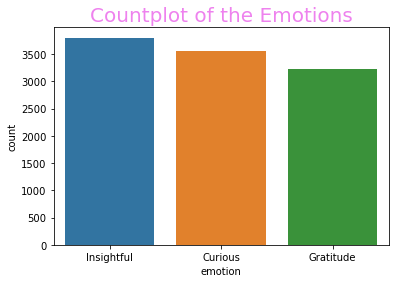

In [110]:
sns.countplot(texts.emotion)
plt.title('Countplot of the Emotions', fontsize = 20, color = 'Violet')
plt.show()


In [111]:
import re,string
import functools  
tokenized_lines = []
def get_clean(text):
        whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
        bangla_fullstop = u"\u0964"
        punctSeq = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
        punc = u"[(),$%^&*+={}\[\]:\"|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"
        text = whitespace.sub(" ", text).strip()
        text = re.sub(r'[^\u0980-\u09FF ]+', '', text)
        text = re.sub(punctSeq, " ", text)
        text = re.sub('\w*\d\w*','',text)
        text = re.sub(bangla_fullstop, " ", text)
        text = re.sub(punc, " ", text)
        text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', ' ', text)
        text=text.replace("\\", " ")
        tokenized_lines.append(text.split())
        return text

In [112]:
df_train['data'] = df_train['data'].apply(lambda x: get_clean(x))
df_train.dropna(subset = ["data"], inplace=True) 
df_test['data'] = df_test['data'].apply(lambda x: get_clean(x))
df_test.dropna(subset = ["data"], inplace=True) 
texts['data'] = texts['data'].apply(lambda x: get_clean(x))
texts.dropna(subset = ["data"], inplace=True) 


In [113]:
now=texts['data'].to_list()
maxlen=0
for i in now:
    z=i.split()
    if(len(z)>maxlen):
        maxlen=len(z)
maxlen

46

In [114]:
X_train=df_train['data']
y_train=df_train['emotion']
X_test=df_test['data']
y_test=df_test['emotion']
X=texts['data']
y_test_sentiment=y_test
y_test_sentiment

0       Insightful
1       Insightful
2       Insightful
3       Insightful
4       Insightful
           ...    
2023     Gratitude
2024     Gratitude
2025     Gratitude
2026     Gratitude
2027     Gratitude
Name: emotion, Length: 2023, dtype: object

In [115]:
class_names = ['Insightful', 'Curious', 'Gratitude']
encoding = {
    'Insightful': 0,
    'Curious': 1,
    'Gratitude': 2,
}
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [116]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
#tokenizer.texts_to_matrix(df['data'], mode='tfidf')
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
vocab_size

10050

In [96]:
preprocessed_text_file_path='vectraindata/bnwiki-texts-preprocessed.txt'                 
lines_from_file = []
with open(preprocessed_text_file_path, encoding='utf8') as text_file:
    for line in text_file:
        lines_from_file.append(line)
for single_line in lines_from_file:
    #print(single_line.split())
    tokenized_lines.append(single_line.split())

In [14]:
import gensim
word_model = gensim.models.Word2Vec(tokenized_lines,vector_size=300,min_count=1)

In [127]:
embedding_matrix = np.zeros((len(word_model.wv.key_to_index) + 1, 300))
for i, vec in enumerate(word_model.wv.vectors):
  embedding_matrix[i] = vec
vocab_size = len(word_model.wv.key_to_index) + 1
vocab_size

672150

In [118]:
embed_num_dims=300
#BidLSTM Starts
# Embedding layer before the actaul BLSTM 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = maxlen,
                         weights = [embedding_matrix],
                         trainable=False)

In [119]:
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(3, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))

In [120]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 46, 300)           201645000 
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               330240    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 201,976,011
Trainable params: 331,011
Non-trainable params: 201,645,000
_________________________________________________________________


In [121]:

# batch_size = 128
batch_size =128
epochs = 32

hist = model.fit(X_train, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test,y_test))



Epoch 1/32
67/67 [==============================] - 52s 703ms/step - loss: 1.0322 - accuracy: 0.4878 - val_loss: 0.8119 - val_accuracy: 0.5922
Epoch 2/32
67/67 [==============================] - 43s 637ms/step - loss: 0.5188 - accuracy: 0.7842 - val_loss: 0.5377 - val_accuracy: 0.7840
Epoch 3/32
67/67 [==============================] - 41s 613ms/step - loss: 0.3402 - accuracy: 0.8707 - val_loss: 0.5660 - val_accuracy: 0.7800
Epoch 4/32
67/67 [==============================] - 37s 547ms/step - loss: 0.2598 - accuracy: 0.9037 - val_loss: 0.5008 - val_accuracy: 0.8122
Epoch 5/32
67/67 [==============================] - 41s 605ms/step - loss: 0.1871 - accuracy: 0.9376 - val_loss: 0.4667 - val_accuracy: 0.8285
Epoch 6/32
67/67 [==============================] - 40s 603ms/step - loss: 0.1467 - accuracy: 0.9560 - val_loss: 0.6443 - val_accuracy: 0.7776
Epoch 7/32
67/67 [==============================] - 39s 585ms/step - loss: 0.1171 - accuracy: 0.9652 - val_loss: 0.5667 - val_accuracy: 0.8265

In [122]:
scores = model.evaluate(X_test, y_test)

64/64 [==============================] - 3s 45ms/step - loss: 0.9144 - accuracy: 0.8492


In [123]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
conf_matrix=confusion_matrix(y_test_sentiment,predictions)
precision_sc = precision_score(y_test_sentiment,predictions,class_names,average='weighted')
recall_sc = recall_score(y_test_sentiment,predictions,class_names,average='weighted')
f1_sc = f1_score(y_test_sentiment,predictions,class_names,average='weighted')
conf_matrix
# y_test_sentiment

array([[ 311,    2,   87],
       [   6,  351,   42],
       [  75,   93, 1056]], dtype=int64)

In [124]:
train_accuracy=scores[1] * 100
test_accuracy=scores[0] * 100
print("Train Accuracy: ",train_accuracy)
print("Test Accuracy: ",test_accuracy)

Train Accuracy:  84.92338061332703
Test Accuracy:  91.43557548522949


In [125]:
print("Precision: ",precision_sc)
print("Recall: ",recall_sc)
print("F1 score: ",f1_sc)


Precision:  0.8512667226483386
Recall:  0.8492338111715274
F1 score:  0.8495868648686585


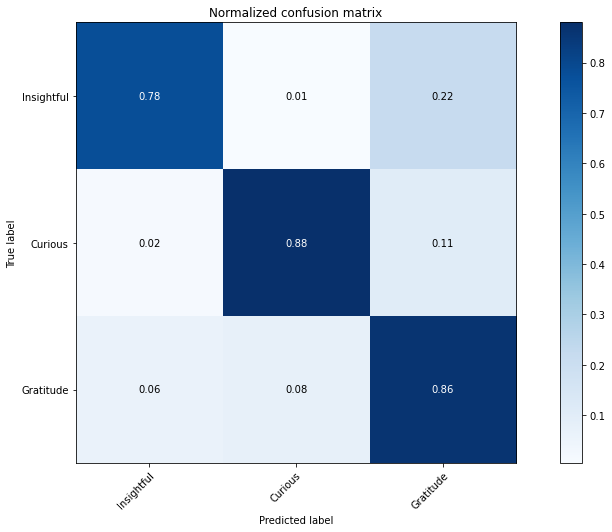

In [126]:
    title='Normalized confusion matrix'
    normalize=True
    cmap=plt.cm.Blues
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =conf_matrix

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


In [18]:
#CNN STarts
# Convolution
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import *
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2)),
# model.add(Dense(1, activation='softmax'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46, 300)           201645000 
_________________________________________________________________
conv1d (Conv1D)              (None, 44, 256)           230656    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 201,942,219
Trainable params: 297,219
Non-trainable params: 201,645,000
__________________________________

In [19]:

# batch_size = 128
batch_size =128
epochs = 32

hist = model.fit(X_train, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test,y_test))



Epoch 1/32
67/67 [==============================] - 7s 77ms/step - loss: 1.4332 - accuracy: 0.5297 - val_loss: 0.5809 - val_accuracy: 0.7608
Epoch 2/32
67/67 [==============================] - 4s 66ms/step - loss: 0.3505 - accuracy: 0.8744 - val_loss: 0.5073 - val_accuracy: 0.7958
Epoch 3/32
67/67 [==============================] - 5s 67ms/step - loss: 0.1612 - accuracy: 0.9535 - val_loss: 0.5125 - val_accuracy: 0.7988
Epoch 4/32
67/67 [==============================] - 4s 66ms/step - loss: 0.0832 - accuracy: 0.9795 - val_loss: 0.5317 - val_accuracy: 0.8057
Epoch 5/32
67/67 [==============================] - 4s 67ms/step - loss: 0.0466 - accuracy: 0.9898 - val_loss: 0.5925 - val_accuracy: 0.8102
Epoch 6/32
67/67 [==============================] - 4s 67ms/step - loss: 0.0241 - accuracy: 0.9959 - val_loss: 0.6926 - val_accuracy: 0.7909
Epoch 7/32
67/67 [==============================] - 5s 68ms/step - loss: 0.0211 - accuracy: 0.9961 - val_loss: 0.6809 - val_accuracy: 0.8329
Epoch 8/32
67

In [20]:
scores = model.evaluate(X_test, y_test)

64/64 [==============================] - 1s 9ms/step - loss: 1.1741 - accuracy: 0.8191


In [21]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]
conf_matrix=confusion_matrix(y_test_sentiment,predictions)
precision_sc = precision_score(y_test_sentiment,predictions,class_names,average='weighted')
recall_sc = recall_score(y_test_sentiment,predictions,class_names,average='weighted')
f1_sc = f1_score(y_test_sentiment,predictions,class_names,average='weighted')
conf_matrix
# y_test_sentiment

array([[317,   7,  76],
       [  6, 346,  47],
       [102, 128, 994]], dtype=int64)

In [22]:
train_accuracy=scores[1] * 100
test_accuracy=scores[0] * 100
print("Train Accuracy: ",train_accuracy)
print("Test Accuracy: ",test_accuracy)

Train Accuracy:  81.90805912017822
Test Accuracy:  117.41342544555664


In [23]:
print("Precision: ",precision_sc)
print("Recall: ",recall_sc)
print("F1 score: ",f1_sc)


Precision:  0.8277731296054961
Recall:  0.819080573405833
F1 score:  0.8208530654287723


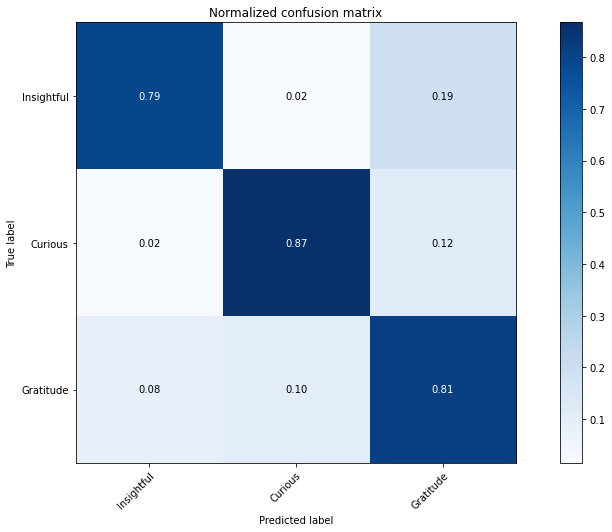

In [24]:
    title='Normalized confusion matrix'
    normalize=True
    cmap=plt.cm.Blues
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =conf_matrix

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
